In [5]:
import sys
import itertools
import pandas as pd
import numpy as np
import pathlib

from tqdm.auto import tqdm

In [2]:
sys.path.append("../src")

from utils import number_split, create_mix

# Load Datasets

## Option 1: Load from preprocessed Toy dataset

In [22]:
df_imdb = pd.read_csv("../dataToy/horror_family.csv")

In [4]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

# Split original dataset into two
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_family = df_imdb.query("domain == 'Family'").reset_index(drop=True)


In [5]:
df_imdb.head()

,id,text,label,score,url,tconst,id_w_tag,set,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,domain,label_binary
0,8286,Larry Fessenden has been thrashed by most of t...,pos,7,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8286,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror,1
1,8279,This film is more about how children make sens...,pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8279,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror,1
2,8273,If you want Scream or anything like the big-st...,pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8273,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror,1
3,8276,"Now this is what I'm talking about. Finally, a...",pos,10,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8276,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror,1
4,8281,"From the first scene, I was really excited. ""I...",pos,7,http://www.imdb.com/title/tt0275067/usercomments,tt0275067,pos_8281,train,movie,Wendigo,Wendigo,0,2001,\N,91,"Horror,Mystery,Thriller",Horror,1


In [6]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_family.groupby("label").size())

label
neg    3055
pos    1167
dtype: int64
label
neg    612
pos    782
dtype: int64


In [7]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_family.groupby("label_binary").size())

label_binary
0    3055
1    1167
dtype: int64
label_binary
0    612
1    782
dtype: int64


## Option 2: Download IMDB Dataset

The link to the original dataset used in this notebook: https://ai.stanford.edu/~amaas/data/sentiment/


For this demo, only data in `train` are used.


- Two provenances: genre-Horror, genre-Family
- Outcome: Positive, Negative

In [16]:
%%bash
cd ../dataToy

wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz >/dev/null 2>&1

tar -xf aclImdb_v1.tar.gz 

In [14]:
%%bash
cd ../dataToy

wget https://datasets.imdbws.com/title.basics.tsv.gz >/dev/null 2>&1

gzip -d title.basics.tsv.gz

In [ ]:
df_ls = []



basepath="../dataToy/aclImdb/"
set_name = "train"

tags = ["pos","neg"]


for tag in tags:
    id_ls = []
    score_ls = []
    text_ls = []
    label_ls = []

    url_ls = []
    tconst_ls = []
    
    path = pathlib.Path(basepath, set_name, tag)
    url_file = pathlib.Path(basepath, set_name, f"urls_{tag}.txt")
    
    with open(url_file, "r") as f:
        _allurls = f.readlines()
        url_ls.append([x.rstrip() for x in _allurls])
        tconst_ls.append([x.rstrip().split("/")[-2] for x in _allurls])
    
    for ifile in path.glob("*"):
        with open(ifile, "r") as f:
            txt = f.readlines()

            text_ls.append(" ".join(txt))





        _id, _score = ifile.with_suffix('').name.split("_")

        id_ls.append(int(_id))
        score_ls.append(_score)
        label_ls.append(tag)

    df_tmp = pd.DataFrame({"id":id_ls,
                         "text":text_ls,
                         "label":label_ls,
                         "score":score_ls,
                        })
    
    df_tmp = df_tmp.set_index('id')

    df_url = pd.DataFrame({"url":url_ls[0], "tconst":tconst_ls[0]})

    df_url.index.name = 'id'

    df_tmp = df_tmp.merge(df_url, on='id')



    assert df_tmp.index.nunique() == len(df_tmp)

    df_tmp['id_w_tag'] = df_tmp.index

    df_tmp['id_w_tag'] = df_tmp['id_w_tag'].apply(lambda x: tag + "_" + str(x))
    df_tmp = df_tmp.reset_index()
    
    df_tmp['set'] = set_name
    
    
    df_ls.append(df_tmp)
    
df = pd.concat(df_ls, ignore_index=True)

# get Genre
df_title_basics = pd.read_csv("../dataToy/title.basics.tsv", sep="\t")
df = df.merge(df_title_basics, on="tconst", how='inner')


# select Horror and Family
df_horror = df[df['genres'].str.contains("Horror")].reset_index(drop=True)
df_horror['domain'] = 'Horror'

df_family = df[df['genres'].str.contains("Family")].reset_index(drop=True)
df_family['domain'] = 'Family'


# Merge and Save
df_mix = pd.concat([df_horror, df_family]).reset_index(drop=True)

df_mix.to_csv("../dataToy/horror_family.csv", index=False)

# Split

## Configs

In [8]:
n_test = 500
train_test_ratio = 4

p_pos_train_z0_ls = [0.3]
p_pos_train_z1_ls = [0.5]
p_mix_z1_ls       = np.arange(0.1, 0.9, 0.05)
alpha_test_ls     = np.arange(0, 10,0.1)

In [9]:
# theoretical numbers



theoretical_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):


    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    # enforce each group*label has at least 10 samples
    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            theoretical_full_settings.append(number_setting)
    

## Inspects

In [10]:
len(theoretical_full_settings)

1187

In [11]:
# check number for one setting
theoretical_full_settings[0]

{'n_train': 2000,
 'n_test': 500,
 'n_z0_pos_train': 540,
 'n_z0_neg_train': 1260,
 'n_z0_pos_test': 150,
 'n_z0_neg_test': 300,
 'n_z1_pos_train': 100,
 'n_z1_neg_train': 100,
 'n_z1_pos_test': 10,
 'n_z1_neg_test': 40,
 'mix_param_dict': {'p_pos_train_z0': 0.3,
  'p_pos_train_z1': 0.5,
  'p_pos_train': 0.32,
  'p_pos_test': 0.32,
  'p_mix_z0': 0.9,
  'p_mix_z1': 0.1,
  'alpha_train': 1.6666666666666667,
  'alpha_test': 0.6000000000000001,
  'p_pos_test_z0': 0.33333333333333337,
  'p_pos_test_z1': 0.20000000000000004,
  'C_y': 0.32,
  'C_z': 0.1}}

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='p_pos_test_z0', ylabel='p_pos_test_z1'>

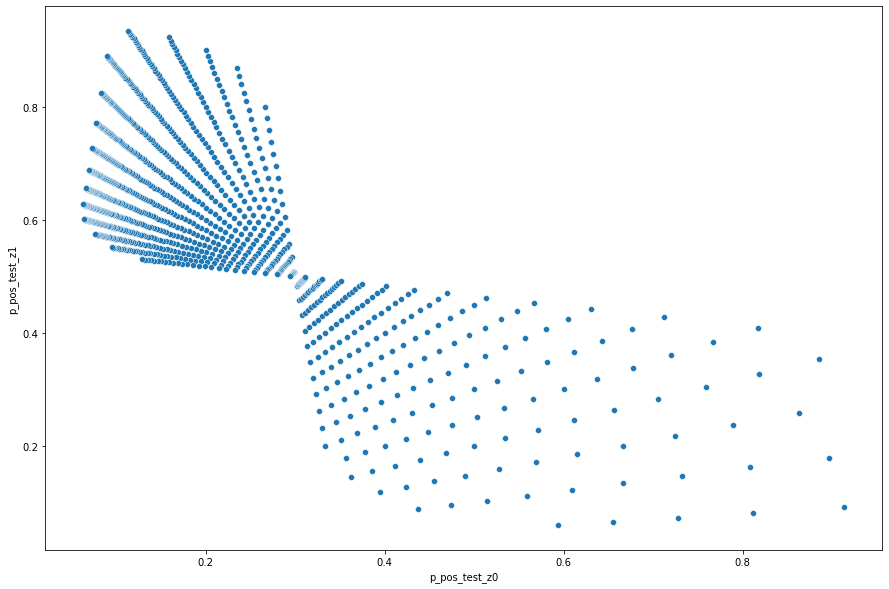

In [13]:
# check distributions of p_pos_test_z0 by p_pos_test_z1
tmp_df = pd.DataFrame([st['mix_param_dict'] for st in theoretical_full_settings])

plt.figure(figsize=(15,10))
sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", data=tmp_df)

## Split Real Datasets

In [14]:
# To ignore warnings when One Theoretical setting could not apply to the real dataset
import warnings
warnings.filterwarnings('ignore')

In [15]:
label='label_binary'
df0 = df_imdb_horror
df1 = df_imdb_family


_rand = 252775

valid_n_full_settings = []

# iterate over theoretical settings
for c in tqdm(theoretical_full_settings):
    c = c.copy()
    dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                     seed=_rand,
                    )

    # one theoretical setting doesn't apply to real dataset
    if dfs is None:
        continue



    #########
    ## Computation here
    #########
    
    # do something with dfs
    
    
    
    # Showcase only
    tmp = dfs
    
    valid_n_full_settings.append(c)

  0%|          | 0/1187 [00:00<?, ?it/s]

## Check Structure of One Resulting `dfs`

In [16]:
tmp.keys()

dict_keys(['train', 'test', 'setting'])

['train'] and ['test'] are of the exact same format as input datasets:

In [17]:
tmp['setting']

{'n_train': 2000,
 'n_test': 500,
 'n_z0_pos_train': 300,
 'n_z0_neg_train': 700,
 'n_z0_pos_test': 18,
 'n_z0_neg_test': 232,
 'n_z1_pos_train': 500,
 'n_z1_neg_train': 500,
 'n_z1_pos_test': 182,
 'n_z1_neg_test': 68,
 'mix_param_dict': {'p_pos_train_z0': 0.3,
  'p_pos_train_z1': 0.5,
  'p_pos_train': 0.4,
  'p_pos_test': 0.4,
  'p_mix_z0': 0.4999999999999999,
  'p_mix_z1': 0.5000000000000001,
  'alpha_train': 1.6666666666666667,
  'alpha_test': 9.9,
  'p_pos_test_z0': 0.07339449541284403,
  'p_pos_test_z1': 0.7266055045871559,
  'C_y': 0.4,
  'C_z': 0.5000000000000001}}

In [18]:
tmp['train'].head()

,id,text,label,score,url,tconst,id_w_tag,set,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,domain,label_binary
0,7893,I guess I'm part of the silent minority who en...,pos,7,http://www.imdb.com/title/tt0101917/usercomments,tt0101917,pos_7893,train,movie,Freddy's Dead: The Final Nightmare,Freddy's Dead: The Final Nightmare,0,1991,\N,89,"Fantasy,Horror",Horror,1
1,7283,"I love buying those cheap, lousy DVD's from Al...",pos,8,http://www.imdb.com/title/tt0052646/usercomments,tt0052646,pos_7283,train,movie,The Brain That Wouldn't Die,The Brain That Wouldn't Die,0,1962,\N,82,"Horror,Sci-Fi",Horror,1
2,7492,Though not a horror film in the traditional se...,pos,7,http://www.imdb.com/title/tt0024727/usercomments,tt0024727,pos_7492,train,movie,The Vampire Bat,The Vampire Bat,0,1933,\N,65,"Drama,Horror,Mystery",Horror,1
3,6164,Are we really making 'video nasties' again? In...,pos,7,http://www.imdb.com/title/tt0400837/usercomments,tt0400837,pos_6164,train,video,Snuff killer - La morte in diretta,Snuff killer - La morte in diretta,0,2003,\N,88,"Horror,Thriller",Horror,1
4,8411,This early version of the tale 'The Student of...,pos,7,http://www.imdb.com/title/tt0003419/usercomments,tt0003419,pos_8411,train,movie,The Student of Prague,Der Student von Prag,0,1913,\N,85,"Drama,Fantasy,Horror",Horror,1


In [19]:
tmp['test'].head()

,id,text,label,score,url,tconst,id_w_tag,set,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,domain,label_binary
0,9156,"I think this movie had to be fun to make it, f...",pos,10,http://www.imdb.com/title/tt0427688/usercomments,tt0427688,pos_9156,train,movie,Studio 666,Studio 666,0,2005,\N,76,"Horror,Music,Sci-Fi",Horror,1
1,9151,Savage Island's raw savagery will scare the he...,pos,10,http://www.imdb.com/title/tt0328378/usercomments,tt0328378,pos_9151,train,movie,Savage Island,Savage Island,0,2004,\N,86,"Horror,Thriller",Horror,1
2,2650,Besides the fact that my list of favorite movi...,pos,10,http://www.imdb.com/title/tt0081505/usercomments,tt0081505,pos_2650,train,movie,The Shining,The Shining,0,1980,\N,146,"Drama,Horror",Horror,1
3,12383,Christina Raines plays a lovely model in New Y...,pos,7,http://www.imdb.com/title/tt0076683/usercomments,tt0076683,pos_12383,train,movie,The Sentinel,The Sentinel,0,1977,\N,92,Horror,Horror,1
4,6131,This is one of the funniest movies that I have...,pos,10,http://www.imdb.com/title/tt0116671/usercomments,tt0116671,pos_6131,train,video,Jack Frost,Jack Frost,0,1997,\N,89,"Comedy,Fantasy,Horror",Horror,1
